In [0]:
import tensorflow as tf
keras, L = tf.keras, tf.keras.layers

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from skimage.transform import resize

In [0]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

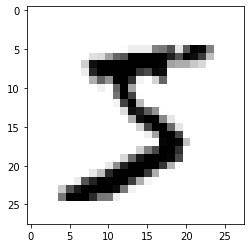

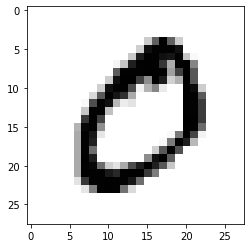

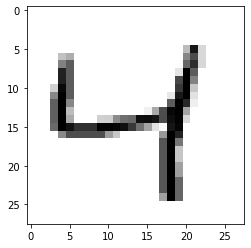

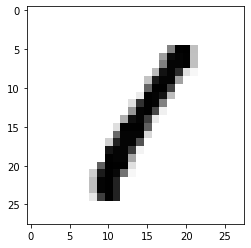

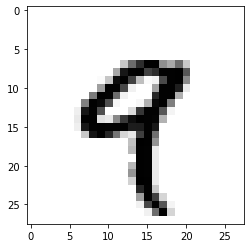

In [5]:
for i in range(5):
    plt.imshow(np.reshape(X[i], (28, 28)), cmap=plt.cm.gray_r)
    plt.show()

In [0]:
train_samples = 5000
test_samples = 1000
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=train_samples, test_size=test_samples, random_state=42)
del X, y

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28))
X_train = np.stack([X_train]*3, axis=-1)
y_train = y_train.astype(int)

X_test = np.reshape(X_test, (X_test.shape[0], 28, 28))
X_test = np.stack([X_test]*3, axis=-1)
y_test = y_test.astype(int)

In [0]:
def resize_image(img):
    img = resize(img, (32, 32), mode='reflect')
    return img

In [0]:
X_train = np.array(list(map(resize_image, X_train)))
X_test = np.array(list(map(resize_image, X_test)))

In [0]:
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
pool = L.GlobalAveragePooling2D()(resnet_model.output)
dense = L.Dense(10, activation='softmax')(pool)
new_model = keras.models.Model(resnet_model.input, dense)
for l in resnet_model.layers:
    l.trainable = True

In [47]:
adam = keras.optimizers.Adam()
new_model.compile(optimizer=adam, 
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="drive/My Drive/Colab Notebooks/mnist.hdf5", 
                                               monitor="val_sparse_categorical_accuracy",
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=4, 
                                             verbose=1)

new_model.fit(X_train, y_train,
              batch_size=32, epochs=20, 
              validation_data=(X_test, y_test), 
              callbacks=[earlystopper, checkpointer])

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
4992/5000 [============================>.] - ETA: 0s - loss: 0.6072 - sparse_categorical_accuracy: 0.8790
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.76600, saving model to drive/My Drive/Colab Notebooks/mnist.hdf5
5000/5000 [==============================] - 32s 6ms/sample - loss: 0.6169 - sparse_categorical_accuracy: 0.8786 - val_loss: 8.1750 - val_sparse_categorical_accuracy: 0.7660
Epoch 2/20
4992/5000 [============================>.] - ETA: 0s - loss: 0.3239 - sparse_categorical_accuracy: 0.9351
Epoch 00002: val_sparse_categorical_accuracy improved from 0.76600 to 0.95500, saving model to drive/My Drive/Colab Notebooks/mnist.hdf5
5000/5000 [==============================] - 22s 4ms/sample - loss: 0.3252 - sparse_categorical_accuracy: 0.9348 - val_loss: 0.1537 - val_sparse_categorical_accuracy: 0.9550
Epoch 3/20
4992/5000 [============================>.] - ETA: 0s - loss: 0.2287 - sparse_categorical

In [0]:
new_model.load_weights("drive/My Drive/Colab Notebooks/mnist.hdf5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted:  8 real:  8


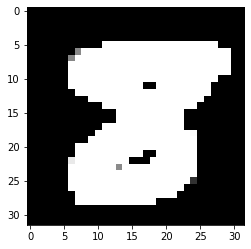

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted:  4 real:  4


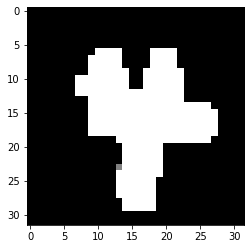

predicted:  8 real:  8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


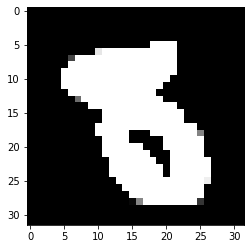

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted:  7 real:  7


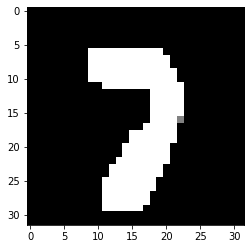

predicted:  7 real:  7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


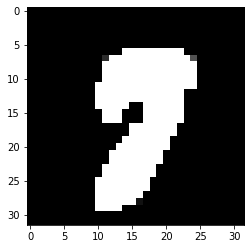

In [15]:
for i in range(5):
  print("predicted: ", np.argmax(new_model.predict([(X_test[i:i+1])])), 
        "real: ", y_test[i])
  plt.imshow(X_test[i])
  plt.show()

In [0]:
def choose_images():
    att_i, ch_i = np.random.randint(len(X_test), size=2)

    attacked_img = X_test[att_i]
    changed_img = X_test[ch_i]

    attacked_img = tf.cast(tf.reshape(attacked_img, [1, *attacked_img.shape]), tf.float32)
    changed_img = tf.cast(tf.reshape(changed_img, [1, *changed_img.shape]), tf.float32)

    print("Attacked image: ")
    print("Logits: ", new_model(attacked_img).numpy()[0])
    print("Predicted: ", np.argmax(new_model(attacked_img)[0]))
    print("Real: ", y_test[att_i])
    plt.imshow(tf.clip_by_value(attacked_img[0], 0, 1))
    plt.show()

    print("Changing image: ")
    print("Logits: ", new_model(changed_img).numpy()[0])
    print("Predicted: ", np.argmax(new_model(changed_img)[0]))
    print("Real: ", y_test[ch_i])
    plt.imshow(tf.clip_by_value(changed_img[0], 0, 1))
    plt.show()
    
    return att_i, attacked_img, ch_i, changed_img

In [0]:
def attack(attacked_img, changed_img, eps=1, fn=tf.identity, iterations=40):  
    y = new_model(attacked_img)

    for i in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(changed_img)
            y_pred = new_model(changed_img)
            loss = tf.reduce_mean((y - y_pred) ** 2)

        gradients, = tape.gradient(loss, changed_img)
        
        changed_img = tf.clip_by_value(changed_img - eps * fn(gradients), 0, 1)
        if i % 10 == 0:
            print("Loss : ", loss.numpy())
            print("Predict of changing image: ", np.argmax(y_pred[0]))
            print("Logits of changing image: ", y_pred.numpy()[0])
            print("Logits of attacked image: ", y.numpy()[0])
            plt.imshow(changed_img[0, :])
            plt.show()


Attacked image: 
Logits:  [1.12760103e-08 4.68073324e-07 2.67534794e-08 2.10075290e-09
 9.99830604e-01 1.38240921e-08 1.67167411e-04 4.13334135e-07
 1.46355035e-08 1.35395919e-06]
Predicted:  4
Real:  4


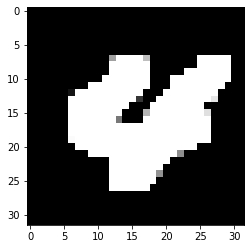

Changing image: 
Logits:  [1.5962446e-33 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0000000e+00 1.5410242e-34 1.1420073e-34 0.0000000e+00 0.0000000e+00]
Predicted:  5
Real:  5


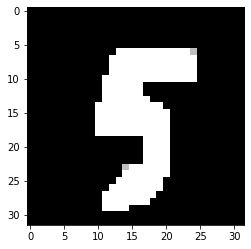

In [18]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.19996612
Predict of changing image:  5
Logits of changing image:  [1.5962446e-33 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0000000e+00 1.5410242e-34 1.1420073e-34 0.0000000e+00 0.0000000e+00]
Logits of attacked image:  [1.12760103e-08 4.68073324e-07 2.67534794e-08 2.10075290e-09
 9.99830604e-01 1.38240921e-08 1.67167411e-04 4.13334135e-07
 1.46355035e-08 1.35395919e-06]


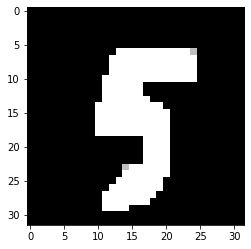

Loss :  0.08402184
Predict of changing image:  1
Logits of changing image:  [0.04903515 0.27189255 0.02871045 0.05082657 0.1533139  0.09919249
 0.05637559 0.05422033 0.11715532 0.11927768]
Logits of attacked image:  [1.12760103e-08 4.68073324e-07 2.67534794e-08 2.10075290e-09
 9.99830604e-01 1.38240921e-08 1.67167411e-04 4.13334135e-07
 1.46355035e-08 1.35395919e-06]


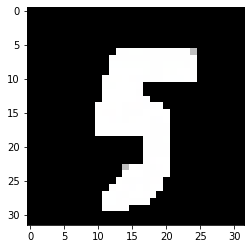

Loss :  0.084021375
Predict of changing image:  1
Logits of changing image:  [0.04903503 0.2718903  0.02871041 0.05082606 0.15331604 0.09919255
 0.05637681 0.05421961 0.11715567 0.11927749]
Logits of attacked image:  [1.12760103e-08 4.68073324e-07 2.67534794e-08 2.10075290e-09
 9.99830604e-01 1.38240921e-08 1.67167411e-04 4.13334135e-07
 1.46355035e-08 1.35395919e-06]


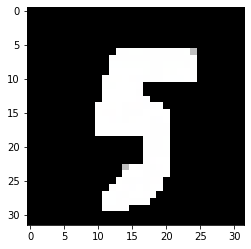

Loss :  0.08402091
Predict of changing image:  1
Logits of changing image:  [0.04903494 0.27188817 0.02871038 0.05082558 0.15331803 0.09919264
 0.05637798 0.05421893 0.11715604 0.11927731]
Logits of attacked image:  [1.12760103e-08 4.68073324e-07 2.67534794e-08 2.10075290e-09
 9.99830604e-01 1.38240921e-08 1.67167411e-04 4.13334135e-07
 1.46355035e-08 1.35395919e-06]


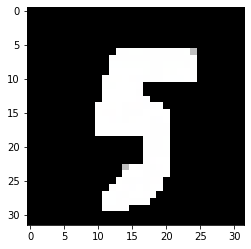

In [19]:
attack(attacked_img, changed_img)

Attacked image: 
Logits:  [4.5093391e-05 9.9916220e-01 2.0070090e-06 1.7811572e-05 8.9678149e-05
 4.9731378e-05 1.6420288e-04 5.2938580e-05 3.3921926e-04 7.7211029e-05]
Predicted:  1
Real:  1


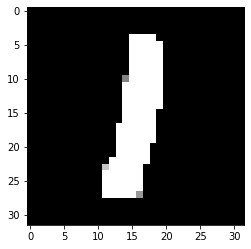

Changing image: 
Logits:  [9.9953938e-01 2.2960587e-07 5.8846803e-05 6.0891540e-07 5.4377051e-06
 7.7840991e-07 2.9478790e-04 7.1320843e-05 4.8744300e-06 2.3758081e-05]
Predicted:  0
Real:  0


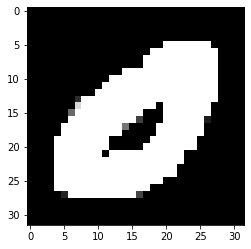

In [99]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.19973135
Predict of changing image:  0
Logits of changing image:  [9.9953938e-01 2.2960587e-07 5.8846803e-05 6.0891540e-07 5.4377051e-06
 7.7840991e-07 2.9478790e-04 7.1320843e-05 4.8744300e-06 2.3758081e-05]
Logits of attacked image:  [4.5093391e-05 9.9916220e-01 2.0070090e-06 1.7811572e-05 8.9678149e-05
 4.9731378e-05 1.6420288e-04 5.2938580e-05 3.3921926e-04 7.7211029e-05]


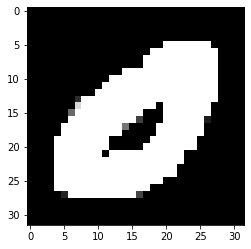

Loss :  0.059664726
Predict of changing image:  1
Logits of changing image:  [0.04895098 0.27527657 0.02857772 0.04999239 0.15435976 0.09675934
 0.05584436 0.05433953 0.1163995  0.1194998 ]
Logits of attacked image:  [4.5093391e-05 9.9916220e-01 2.0070090e-06 1.7811572e-05 8.9678149e-05
 4.9731378e-05 1.6420288e-04 5.2938580e-05 3.3921926e-04 7.7211029e-05]


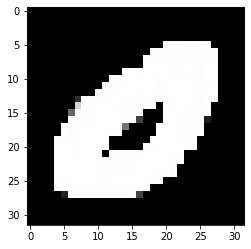

Loss :  0.059663124
Predict of changing image:  1
Logits of changing image:  [0.04895045 0.2752864  0.0285773  0.0499917  0.15435816 0.09675651
 0.0558422  0.05433959 0.11639839 0.11949921]
Logits of attacked image:  [4.5093391e-05 9.9916220e-01 2.0070090e-06 1.7811572e-05 8.9678149e-05
 4.9731378e-05 1.6420288e-04 5.2938580e-05 3.3921926e-04 7.7211029e-05]


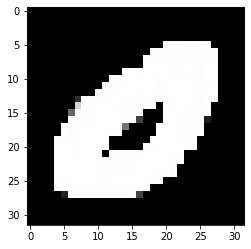

Loss :  0.0596615
Predict of changing image:  1
Logits of changing image:  [0.0489499  0.2752963  0.02857689 0.049991   0.15435669 0.09675366
 0.05584007 0.05433963 0.11639727 0.11949862]
Logits of attacked image:  [4.5093391e-05 9.9916220e-01 2.0070090e-06 1.7811572e-05 8.9678149e-05
 4.9731378e-05 1.6420288e-04 5.2938580e-05 3.3921926e-04 7.7211029e-05]


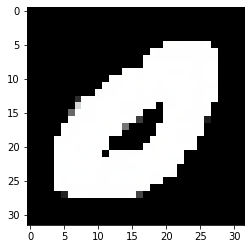

Loss :  0.059659936
Predict of changing image:  1
Logits of changing image:  [0.04894941 0.27530596 0.02857648 0.04999037 0.15435493 0.09675093
 0.0558379  0.05433974 0.1163962  0.11949809]
Logits of attacked image:  [4.5093391e-05 9.9916220e-01 2.0070090e-06 1.7811572e-05 8.9678149e-05
 4.9731378e-05 1.6420288e-04 5.2938580e-05 3.3921926e-04 7.7211029e-05]


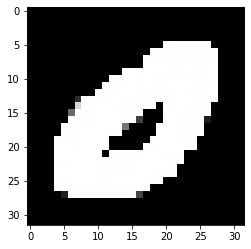

In [106]:
attack(attacked_img, changed_img)

Loss :  0.19973135
Predict of changing image:  0
Logits of changing image:  [9.9953938e-01 2.2960587e-07 5.8846803e-05 6.0891540e-07 5.4377051e-06
 7.7840991e-07 2.9478790e-04 7.1320843e-05 4.8744300e-06 2.3758081e-05]
Logits of attacked image:  [4.5093391e-05 9.9916220e-01 2.0070090e-06 1.7811572e-05 8.9678149e-05
 4.9731378e-05 1.6420288e-04 5.2938580e-05 3.3921926e-04 7.7211029e-05]


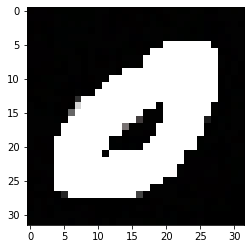

Loss :  0.05885349
Predict of changing image:  1
Logits of changing image:  [0.04864261 0.28026    0.02841821 0.04967739 0.1536304  0.09532326
 0.05478039 0.05439464 0.11575755 0.11911552]
Logits of attacked image:  [4.5093391e-05 9.9916220e-01 2.0070090e-06 1.7811572e-05 8.9678149e-05
 4.9731378e-05 1.6420288e-04 5.2938580e-05 3.3921926e-04 7.7211029e-05]


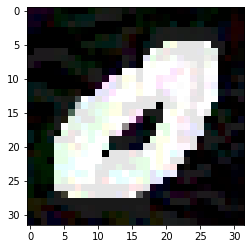

Loss :  0.058064513
Predict of changing image:  1
Logits of changing image:  [0.04830366 0.28513512 0.0282596  0.04940697 0.15291943 0.09401207
 0.053815   0.0544254  0.1150825  0.11864025]
Logits of attacked image:  [4.5093391e-05 9.9916220e-01 2.0070090e-06 1.7811572e-05 8.9678149e-05
 4.9731378e-05 1.6420288e-04 5.2938580e-05 3.3921926e-04 7.7211029e-05]


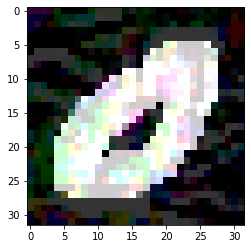

Loss :  0.057335425
Predict of changing image:  1
Logits of changing image:  [0.04793899 0.28966036 0.02810185 0.04921784 0.15217955 0.09298512
 0.05300423 0.05438703 0.11445921 0.11806577]
Logits of attacked image:  [4.5093391e-05 9.9916220e-01 2.0070090e-06 1.7811572e-05 8.9678149e-05
 4.9731378e-05 1.6420288e-04 5.2938580e-05 3.3921926e-04 7.7211029e-05]


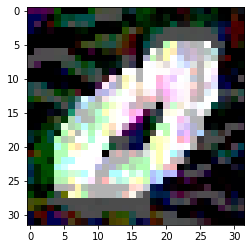

Loss :  0.056653023
Predict of changing image:  1
Logits of changing image:  [0.04761347 0.29390204 0.02796757 0.04911093 0.15129624 0.09211083
 0.05220491 0.05440078 0.11386835 0.11752491]
Logits of attacked image:  [4.5093391e-05 9.9916220e-01 2.0070090e-06 1.7811572e-05 8.9678149e-05
 4.9731378e-05 1.6420288e-04 5.2938580e-05 3.3921926e-04 7.7211029e-05]


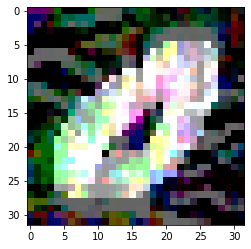

In [107]:
attack(attacked_img, changed_img, eps=0.01, fn=tf.sign)

Attacked image: 
Logits:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]
Predicted:  2
Real:  2


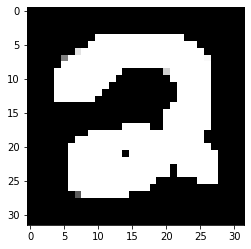

Changing image: 
Logits:  [7.15581564e-06 6.75191177e-06 3.40865472e-06 1.15127325e-04
 3.84732895e-03 8.39326185e-06 3.31911406e-06 4.01360868e-03
 3.40251339e-04 9.91654634e-01]
Predicted:  9
Real:  9


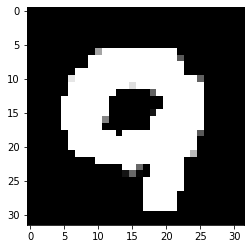

In [110]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.19809057
Predict of changing image:  9
Logits of changing image:  [7.15581564e-06 6.75191177e-06 3.40865472e-06 1.15127325e-04
 3.84732895e-03 8.39326185e-06 3.31911406e-06 4.01360868e-03
 3.40251339e-04 9.91654634e-01]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


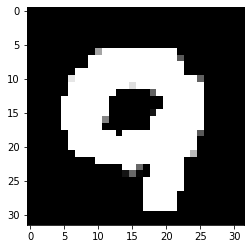

Loss :  0.10872716
Predict of changing image:  1
Logits of changing image:  [0.04920069 0.27194175 0.02876841 0.05032227 0.15503217 0.09728319
 0.05607931 0.05490619 0.11634149 0.12012446]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


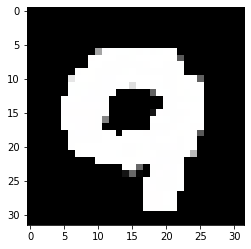

Loss :  0.10872708
Predict of changing image:  1
Logits of changing image:  [0.04920078 0.27194014 0.02876847 0.05032252 0.1550321  0.09728387
 0.05607953 0.05490621 0.11634175 0.12012458]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


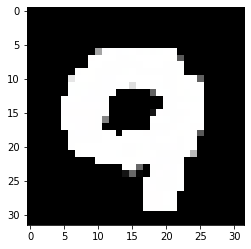

Loss :  0.10872702
Predict of changing image:  1
Logits of changing image:  [0.04920086 0.2719389  0.02876855 0.05032265 0.15503211 0.09728438
 0.05607984 0.0549062  0.11634193 0.12012462]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


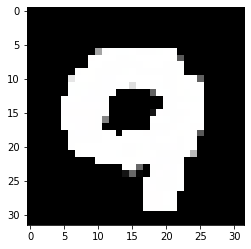

Loss :  0.10872694
Predict of changing image:  1
Logits of changing image:  [0.04920096 0.27193728 0.0287686  0.05032285 0.15503202 0.09728505
 0.05608014 0.05490617 0.11634218 0.12012465]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


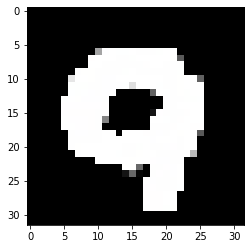

In [111]:
attack(attacked_img, changed_img)

Loss :  0.19809057
Predict of changing image:  9
Logits of changing image:  [7.15581564e-06 6.75191177e-06 3.40865472e-06 1.15127325e-04
 3.84732895e-03 8.39326185e-06 3.31911406e-06 4.01360868e-03
 3.40251339e-04 9.91654634e-01]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


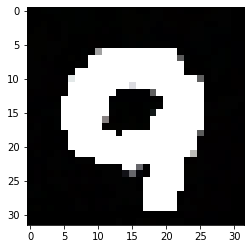

Loss :  0.10856551
Predict of changing image:  1
Logits of changing image:  [0.04941259 0.26870844 0.02894159 0.05084162 0.15477028 0.09869582
 0.05661387 0.05500662 0.11675038 0.12025877]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


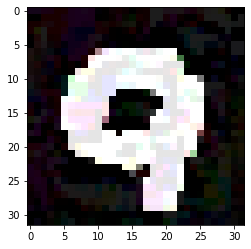

Loss :  0.108405605
Predict of changing image:  1
Logits of changing image:  [0.04962336 0.26550388 0.02911877 0.05138449 0.15444519 0.10015094
 0.05714041 0.05511294 0.11714677 0.1203732 ]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


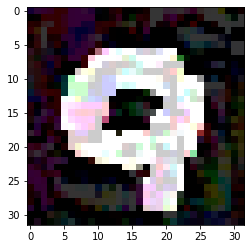

Loss :  0.108250424
Predict of changing image:  1
Logits of changing image:  [0.04982017 0.262374   0.02929835 0.05192452 0.1541297  0.10159885
 0.05766542 0.05521182 0.11751931 0.12045783]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


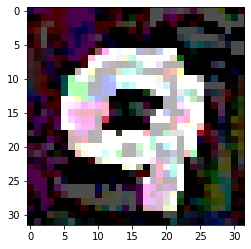

Loss :  0.1081059
Predict of changing image:  1
Logits of changing image:  [0.04999483 0.25942245 0.029469   0.05244953 0.15381846 0.10300536
 0.05815939 0.05530355 0.11785954 0.12051786]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


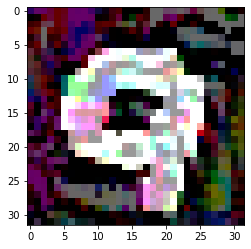

In [112]:
attack(attacked_img, changed_img, eps=0.01, fn=tf.sign)

Loss :  0.19809057
Predict of changing image:  9
Logits of changing image:  [7.15581564e-06 6.75191177e-06 3.40865472e-06 1.15127325e-04
 3.84732895e-03 8.39326185e-06 3.31911406e-06 4.01360868e-03
 3.40251339e-04 9.91654634e-01]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


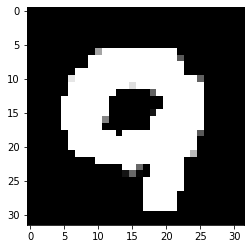

Loss :  0.108727075
Predict of changing image:  1
Logits of changing image:  [0.0492008  0.2719399  0.02876849 0.05032258 0.15503201 0.09728403
 0.05607956 0.05490625 0.11634176 0.1201246 ]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


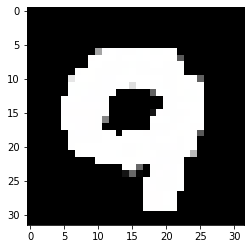

Loss :  0.108726904
Predict of changing image:  1
Logits of changing image:  [0.04920105 0.2719362  0.02876867 0.05032314 0.15503171 0.09728561
 0.05608018 0.05490636 0.11634224 0.1201248 ]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


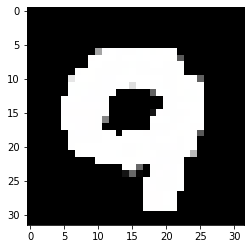

Loss :  0.108726695
Predict of changing image:  1
Logits of changing image:  [0.04920133 0.27193233 0.02876887 0.05032375 0.15503137 0.09728729
 0.05608083 0.05490647 0.11634278 0.12012499]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


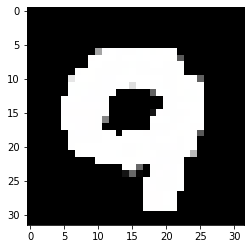

Loss :  0.10872652
Predict of changing image:  1
Logits of changing image:  [0.0492016  0.27192852 0.02876909 0.05032431 0.15503116 0.09728884
 0.05608144 0.0549066  0.11634324 0.12012518]
Logits of attacked image:  [1.1645004e-03 7.3835416e-08 9.9875093e-01 6.3621610e-07 3.8707194e-06
 5.1109220e-07 1.6472695e-06 7.5919095e-05 1.2578606e-06 7.6035093e-07]


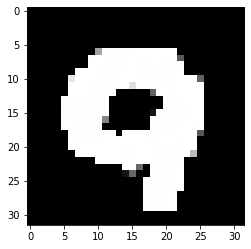

In [113]:
attack(attacked_img, changed_img, eps=0.00001, fn=tf.sign)

Attacked image: 
Logits:  [1.9210557e-07 9.7757242e-09 7.5293570e-08 8.3065804e-11 3.7886061e-06
 6.3339847e-08 9.9999583e-01 8.3904689e-10 1.3333681e-07 5.7010829e-10]
Predicted:  6
Real:  6


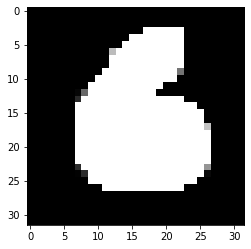

Changing image: 
Logits:  [1.9018836e-12 1.2024155e-10 1.7322364e-12 1.9490941e-10 3.4501414e-14
 1.1191526e-11 1.3218589e-12 1.0000000e+00 2.0461005e-13 2.3653170e-08]
Predicted:  7
Real:  7


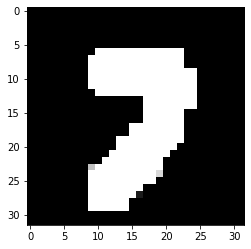

In [114]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.19999917
Predict of changing image:  7
Logits of changing image:  [1.9018836e-12 1.2024155e-10 1.7322364e-12 1.9490941e-10 3.4501414e-14
 1.1191526e-11 1.3218589e-12 1.0000000e+00 2.0461005e-13 2.3653170e-08]
Logits of attacked image:  [1.9210557e-07 9.7757242e-09 7.5293570e-08 8.3065804e-11 3.7886061e-06
 6.3339847e-08 9.9999583e-01 8.3904689e-10 1.3333681e-07 5.7010829e-10]


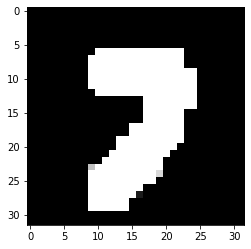

Loss :  0.10419442
Predict of changing image:  1
Logits of changing image:  [0.04880418 0.27995783 0.02856072 0.05047233 0.15196283 0.09611958
 0.05403137 0.05518092 0.11556911 0.11934122]
Logits of attacked image:  [1.9210557e-07 9.7757242e-09 7.5293570e-08 8.3065804e-11 3.7886061e-06
 6.3339847e-08 9.9999583e-01 8.3904689e-10 1.3333681e-07 5.7010829e-10]


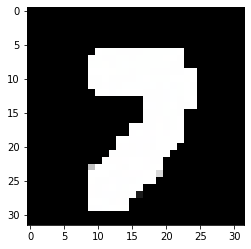

Loss :  0.104194164
Predict of changing image:  1
Logits of changing image:  [0.04880431 0.27995518 0.0285608  0.05047229 0.15196358 0.09612019
 0.05403209 0.05518064 0.11556958 0.11934133]
Logits of attacked image:  [1.9210557e-07 9.7757242e-09 7.5293570e-08 8.3065804e-11 3.7886061e-06
 6.3339847e-08 9.9999583e-01 8.3904689e-10 1.3333681e-07 5.7010829e-10]


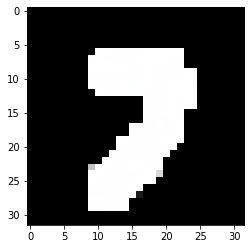

Loss :  0.104193926
Predict of changing image:  1
Logits of changing image:  [0.04880443 0.27995238 0.02856092 0.05047221 0.15196459 0.09612071
 0.05403289 0.0551804  0.11556996 0.11934146]
Logits of attacked image:  [1.9210557e-07 9.7757242e-09 7.5293570e-08 8.3065804e-11 3.7886061e-06
 6.3339847e-08 9.9999583e-01 8.3904689e-10 1.3333681e-07 5.7010829e-10]


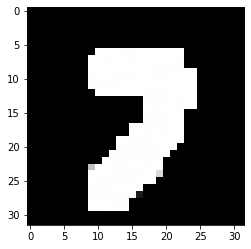

Loss :  0.10419367
Predict of changing image:  1
Logits of changing image:  [0.04880456 0.27994975 0.02856101 0.05047211 0.15196554 0.09612121
 0.05403364 0.05518014 0.11557043 0.1193416 ]
Logits of attacked image:  [1.9210557e-07 9.7757242e-09 7.5293570e-08 8.3065804e-11 3.7886061e-06
 6.3339847e-08 9.9999583e-01 8.3904689e-10 1.3333681e-07 5.7010829e-10]


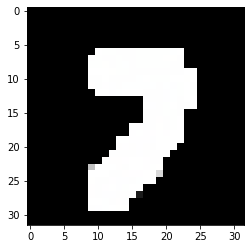

In [115]:
attack(attacked_img, changed_img)

Attacked image: 
Logits:  [2.8941653e-07 1.4402065e-05 8.6057204e-04 9.9708706e-01 1.8241649e-07
 2.0503487e-04 1.5083789e-06 7.3372154e-04 9.4481860e-04 1.5238643e-04]
Predicted:  3
Real:  3


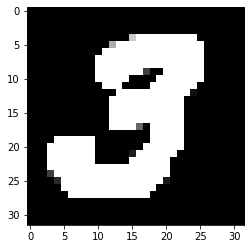

Changing image: 
Logits:  [4.2792829e-04 2.4181604e-04 3.4376007e-04 4.3409073e-04 5.0163082e-05
 6.9460608e-03 3.5760102e-03 3.2269866e-06 9.8736340e-01 6.1354187e-04]
Predicted:  8
Real:  8


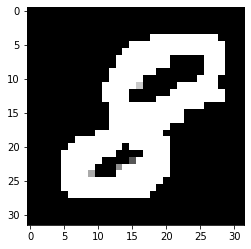

In [190]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.19663982
Predict of changing image:  8
Logits of changing image:  [4.2792829e-04 2.4181604e-04 3.4376007e-04 4.3409073e-04 5.0163082e-05
 6.9460608e-03 3.5760102e-03 3.2269866e-06 9.8736340e-01 6.1354187e-04]
Logits of attacked image:  [2.8941653e-07 1.4402065e-05 8.6057204e-04 9.9708706e-01 1.8241649e-07
 2.0503487e-04 1.5083789e-06 7.3372154e-04 9.4481860e-04 1.5238643e-04]


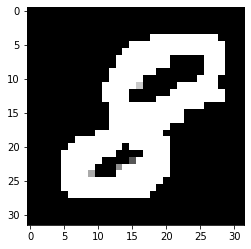

Loss :  0.10397196
Predict of changing image:  1
Logits of changing image:  [0.04872966 0.2720452  0.02874109 0.05078889 0.15365013 0.09969746
 0.05701351 0.05355795 0.11733621 0.11843986]
Logits of attacked image:  [2.8941653e-07 1.4402065e-05 8.6057204e-04 9.9708706e-01 1.8241649e-07
 2.0503487e-04 1.5083789e-06 7.3372154e-04 9.4481860e-04 1.5238643e-04]


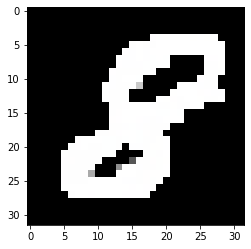

Loss :  0.10397182
Predict of changing image:  1
Logits of changing image:  [0.04872981 0.27204356 0.02874122 0.05078924 0.15364984 0.09969816
 0.05701365 0.05355815 0.11733636 0.11844002]
Logits of attacked image:  [2.8941653e-07 1.4402065e-05 8.6057204e-04 9.9708706e-01 1.8241649e-07
 2.0503487e-04 1.5083789e-06 7.3372154e-04 9.4481860e-04 1.5238643e-04]


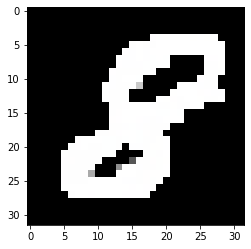

Loss :  0.10397168
Predict of changing image:  1
Logits of changing image:  [0.04872996 0.27204183 0.02874135 0.05078962 0.15364951 0.09969891
 0.05701376 0.05355834 0.11733654 0.11844017]
Logits of attacked image:  [2.8941653e-07 1.4402065e-05 8.6057204e-04 9.9708706e-01 1.8241649e-07
 2.0503487e-04 1.5083789e-06 7.3372154e-04 9.4481860e-04 1.5238643e-04]


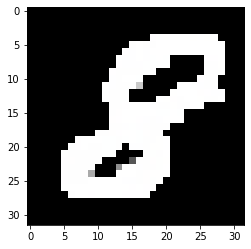

In [191]:
attack(attacked_img, changed_img)